# 0. 환경설정

In [1]:
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import zscore
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_colwidth', 30)
pd.options.display.float_format = '{:.5f}'.format

# 1. 데이터 이해 (Data Understanding)

In [2]:
raw_data = pd.read_csv('./data/공모전데이터_분석용_KOTRA_0525.csv', dtype={'HSCD': str}) 
submission = pd.read_csv('./data/공모전데이터_예측용_KOTRA_0525.csv', dtype={'HSCD': str})

In [3]:
raw_data.head(5)

,UNC_YEAR,HSCD,COUNTRYCD,COUNTRYNM,TRADE_COUNTRYCD,TRADE_HSCD,TARIFF_AVG,SNDIST,NY_GDP_MKTP_CD,NY_GDP_MKTP_CD_1Y,SP_POP_TOTL,PA_NUS_FCRF,IC_BUS_EASE_DFRN_DB,KMDIST,TRADE_HSCD_COUNTRYCD,KR_TRADE_HSCD_COUNTRYCD
0,2017,190590,12,Algeria,46052990973,19480986257,30.00000,3878.23844,170163165961,159994837855,41389198,110.97302,46.10981,9954.00977,3416326.00000,7657
1,2017,190590,36,Australia,228441691195,19480986257,0.00000,12203.15598,1329188475752,1208846993740,24601860,1.30476,80.22369,8329.65234,438747025.00000,5294788
2,2017,190590,40,Austria,166475020975,19480986257,0.00000,4403.24729,417237869116,395568644341,8797566,NaN,78.85646,8289.02930,453206357.00000,335818
3,2017,190590,56,Belgium,406412223480,19480986257,0.00000,3980.37556,502698069367,475739588765,11375158,NaN,72.40920,8722.11426,706524512.00000,173709
4,2017,190590,76,Brazil,150749493921,19480986257,18.00000,9644.20694,2062831045936,1795700168991,207833831,3.19139,55.38240,18364.50586,31329648.00000,122850


Submission에 대해 데이터의 이해는 raw_data와 상당히 유사하여 raw_data에 대한 데이터 이해만 서술하였음.

### 1.1) 데이터 파악

In [4]:
print('HSCD 품목 개수는 총 {} 개 이며, 국가의 개수는 총 {} 개'.format(len(raw_data.HSCD.unique()), len(raw_data.COUNTRYNM.unique())))

HSCD 품목 개수는 총 500 개 이며, 국가의 개수는 총 43 개


<AxesSubplot:xlabel='COUNTRYCD', ylabel='Density'>

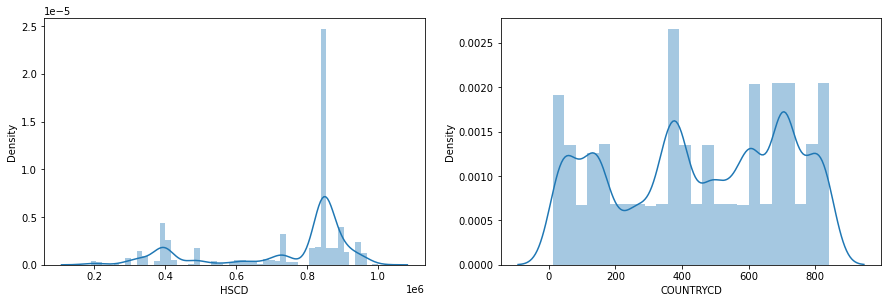

In [5]:
fig = plt.figure(figsize = (15,10))
ax1 = fig.add_subplot(2,2,1)
sns.distplot(raw_data['HSCD'], ax = ax1)

ax2 = fig.add_subplot(2,2,2)
sns.distplot(raw_data['COUNTRYCD'], ax = ax2)

- 특정 품목 및 국가에 대한 분포를 확인한 결과, 편향된 것은 확인되지 않음 

### 1.2) 변수간 상관관계 파악

<AxesSubplot:>

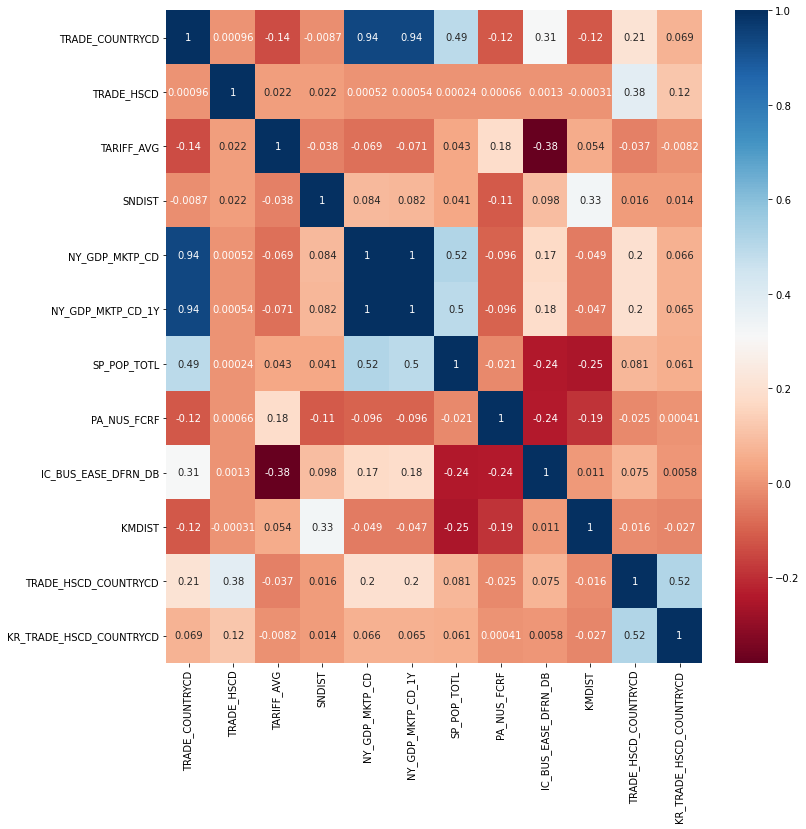

In [6]:
cor_data = raw_data.copy()
cor_data.drop(['UNC_YEAR', 'HSCD', 'COUNTRYCD', 'COUNTRYNM'], axis = 1, inplace = True)
corr = cor_data[cor_data.columns.tolist()].corr()

plt.figure(figsize =(12,12))
sns.heatmap(corr,cmap='RdBu', annot = True)

- TRADE_COUNTRYCD와 NY_GDP_MKTP_CD(GDP), NY_GDP_MKTP_CD_1Y(이전 GDP)와의 양의 상관관계가 높게 나타남.

### 1.3) 결측값(Missing Value) 파악

In [7]:
# raw_data 결측값 확인
missing_col = raw_data.columns[raw_data.isnull().sum() > 0].to_list()

print('1) 결측치 칼럼')
print(missing_col)
print('=======================================')

print('2) 결측치 수')
print(raw_data[missing_col].isnull().sum())
print('=======================================')

print('3) 결측치 비율')
print(round(raw_data[missing_col].isnull().sum() /len(raw_data) * 100,2))

1) 결측치 칼럼
['TARIFF_AVG', 'SNDIST', 'PA_NUS_FCRF', 'TRADE_HSCD_COUNTRYCD']
2) 결측치 수
TARIFF_AVG               129
SNDIST                    22
PA_NUS_FCRF             3488
TRADE_HSCD_COUNTRYCD      21
dtype: int64
3) 결측치 비율
TARIFF_AVG              0.61000
SNDIST                  0.10000
PA_NUS_FCRF            16.46000
TRADE_HSCD_COUNTRYCD    0.10000
dtype: float64


In [8]:
# submission 결측값 확인
missing_col2 = submission.columns[submission.isnull().sum() > 0].to_list()

print('- 결측치 칼럼')
print(missing_col)
print('=======================================')

print('- 결측치 수')
print(submission[missing_col2].isnull().sum())
print('=======================================')

print('- 결측치 비율')
print(round(submission[missing_col2].isnull().sum() /len(submission) * 100,2))

- 결측치 칼럼
['TARIFF_AVG', 'SNDIST', 'PA_NUS_FCRF', 'TRADE_HSCD_COUNTRYCD']
- 결측치 수
TARIFF_AVG                   625
SNDIST                         3
PA_NUS_FCRF                 3488
TRADE_HSCD_COUNTRYCD           3
KR_TRADE_HSCD_COUNTRYCD    21189
dtype: int64
- 결측치 비율
TARIFF_AVG                  2.95000
SNDIST                      0.01000
PA_NUS_FCRF                16.46000
TRADE_HSCD_COUNTRYCD        0.01000
KR_TRADE_HSCD_COUNTRYCD   100.00000
dtype: float64


#### 결측치 칼럼
- TARIFF_AVG : 해당 국가에서 해당 품목에 적용되는 평균 관세율
- SNDIST : 해당 국가와 수입 국가 간 평균 거리
- PA_NUS_FCRF : 공식 환율 (미국 달러에 대한 현지 통화 단위, 월평균을 기준으로 한 연평균)
- TRADE_HSCD_COUNTRYCD : 해당 연도 해당 국가의 해당 품목 수입금액
---
- PA_NUS_FCRF는 3,488건의 결측 수를 가지고 있으며, 16%가 넘는 비율로 결측값 처리 필요성 있음 <br>
 그 외 변수의 경우 결측 비율이 전체의 최대 3%를 넘지 않지만, 모델의 범용성을 위해 다른 변수의 관계를 이용하는 함수 위주로 결측값 대체 예정

### 1.4) 이상값(Oulier Value) 파악

<AxesSubplot:xlabel='TRADE_HSCD_COUNTRYCD', ylabel='Density'>

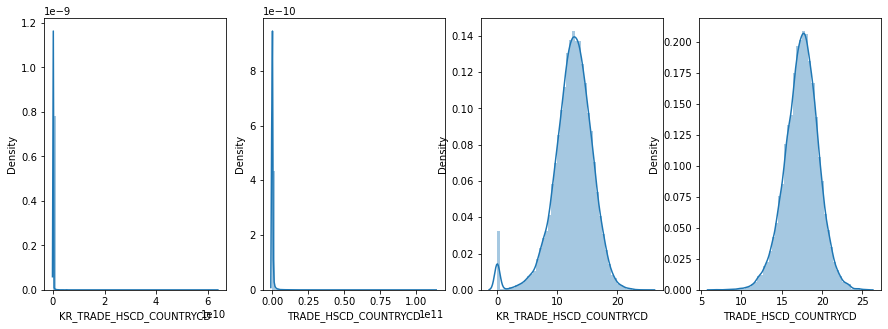

In [9]:
fig = plt.figure(figsize = (15,5))
ax1 = fig.add_subplot(1,4,1)
sns.distplot(raw_data['KR_TRADE_HSCD_COUNTRYCD'], ax = ax1)

ax2 = fig.add_subplot(1,4,2)
sns.distplot(raw_data['TRADE_HSCD_COUNTRYCD'], ax = ax2)

ax3 = fig.add_subplot(1,4,3)
sns.distplot(np.log1p(raw_data["KR_TRADE_HSCD_COUNTRYCD"]), ax = ax3)

ax4 = fig.add_subplot(1,4,4)
sns.distplot(np.log1p(raw_data["TRADE_HSCD_COUNTRYCD"]), ax = ax4)

- 종속 변수인 KR_TRADE_HSCD_COUNTRYCD와 TRADE_HSCD_COUNTRYCD에 대해 심한 왜도(Skewness) 형태를 확인함 추후 이를 로그(Log)변환 하여 전처리할 필요성이 있음.
- 로그 변환 이후 정규분포의 값을 보이나, Log가 0인 부분을 확인할 수 있음. 
- 이는 향후 데이터 모델링 부분에서 전처리할 필요성이 있음.

In [10]:
raw_data.describe()

,UNC_YEAR,COUNTRYCD,TRADE_COUNTRYCD,TRADE_HSCD,TARIFF_AVG,SNDIST,NY_GDP_MKTP_CD,NY_GDP_MKTP_CD_1Y,SP_POP_TOTL,PA_NUS_FCRF,IC_BUS_EASE_DFRN_DB,KMDIST,TRADE_HSCD_COUNTRYCD,KR_TRADE_HSCD_COUNTRYCD
count,21189.00000,21189.00000,21189.00000,21189.00000,21060.00000,21167.00000,21189.00000,21189.00000,21189.00000,17701.00000,21189.00000,21189.00000,21168.00000,21189.00000
mean,2017.00000,450.41111,342490635790.14844,15169280109.56931,3.27147,6368.11047,1644687335676.05127,1547985101355.80493,122508699.81344,1993.84203,70.72344,7951.61674,308334486.11588,17939631.96140
std,0.00000,254.19937,463919395070.34802,39156772230.03516,8.69924,2518.06137,3433911976109.43848,3257227668213.08008,284441865.34086,6568.36670,10.56213,4054.05756,2130044165.52043,481003321.42677
min,2017.00000,12.00000,4337305039.00000,243682115.00000,0.00000,1172.04724,11425755280.00000,11186734674.00000,3113779.00000,0.30335,42.67139,955.65106,763.00000,0.00000
25%,2017.00000,203.00000,66338749061.00000,2469927278.00000,0.00000,4376.30316,235733695652.00000,250440136356.00000,11375158.00000,3.19139,64.52893,4692.67188,10323668.50000,49170.00000
50%,2017.00000,458.00000,213215271369.00000,4849946515.00000,0.00000,5624.93002,445345256459.00000,417983583566.00000,37974826.00000,7.79325,73.39408,8262.06250,40821731.50000,349649.00000
75%,2017.00000,699.00000,432405117520.00000,11885587078.00000,5.00000,7877.52495,1574199387071.00000,1276786979222.00000,94596642.00000,110.97302,78.27291,9954.00977,145639490.00000,2307592.00000
max,2017.00000,842.00000,2405276626657.00000,393706362343.00000,515.00000,15134.16411,19519353692000.00000,18714960538000.00000,1386395000.00000,33226.29815,87.16633,18375.18164,113073000000.00000,63695330669.00000


- 종속변수인 KR_TRADE_HSCD_COUNTRYCD와 TRADE_HSCD_COUNTRYCD에 대해선 모델 예측부분에서 이상치 처리하기로 함.

### Turkey Fences
- Q1 - (1.5 * IQR) 미만, Q3 + (1.5 * IQR) 초과인 이상값 파악

In [11]:
Outlier_Check = raw_data.select_dtypes(include=np.number).dropna()
Outlier_Check = Outlier_Check[Outlier_Check.columns.difference(['UNC_YEAR'])] 

In [12]:
def find_outlier_Turkey(data):
    q1, q3 = np.percentile(data, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - (iqr * 1.5)
    upper_bound = q3 + (iqr * 1.5)
    mask = np.where((data > upper_bound) | (data < lower_bound))
    return mask

find_outlier_Turkey(Outlier_Check)

(array([    0,     0,     0, ..., 17582, 17582, 17582], dtype=int64),
 array([ 4,  5, 10, ...,  4,  5, 10], dtype=int64))

<AxesSubplot:>

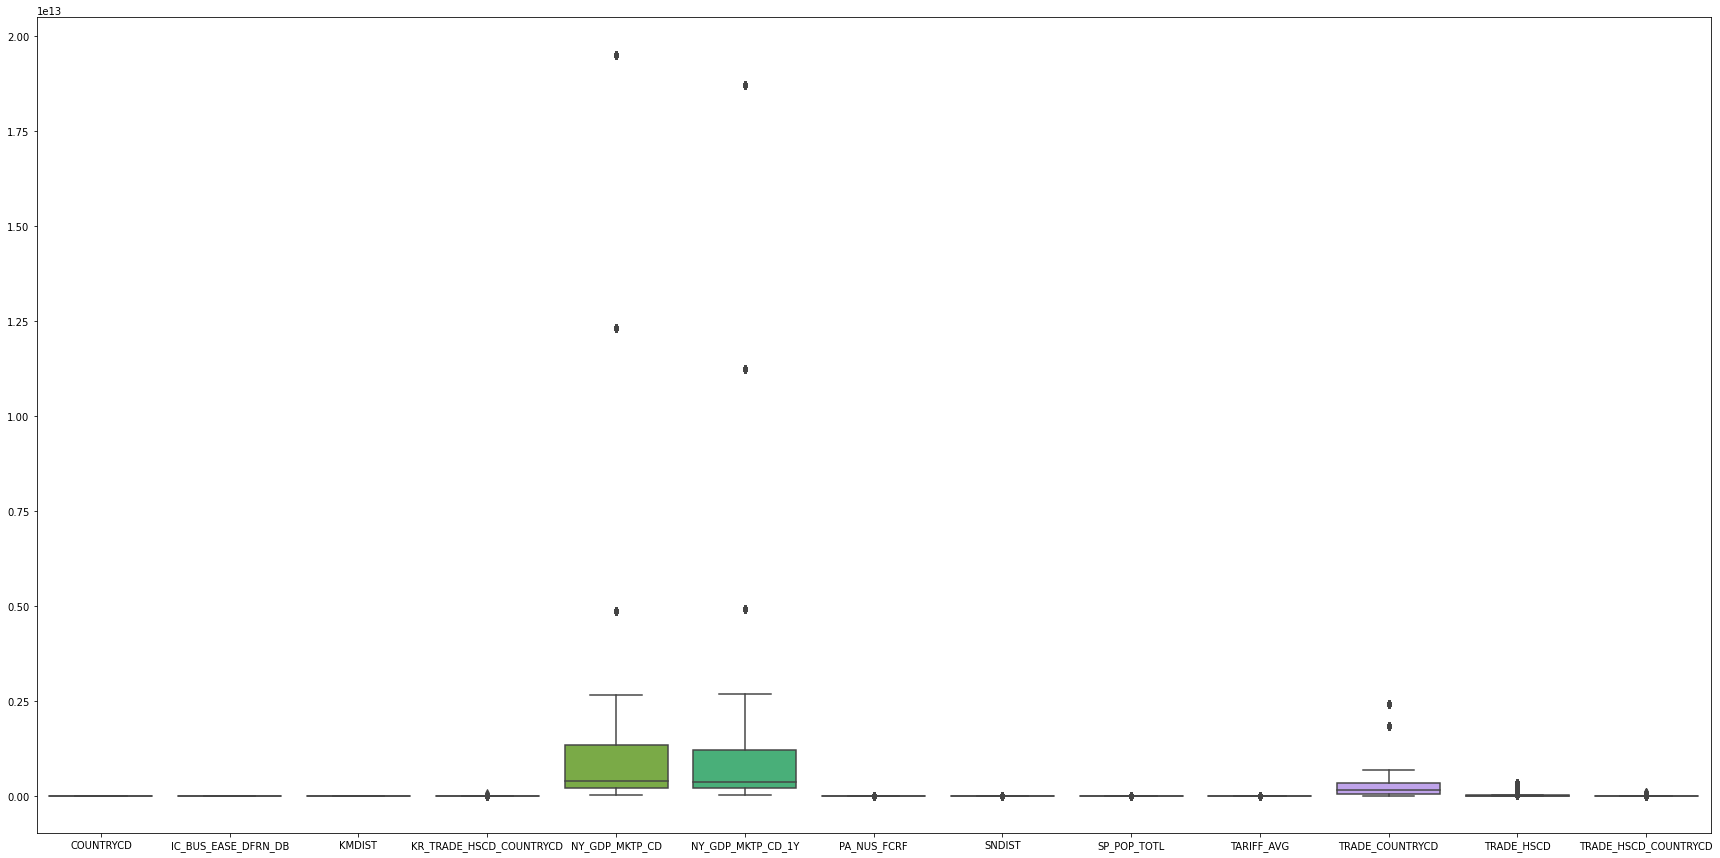

In [13]:
# box plot 시각화
plt.figure(figsize = (30,15))
sns.boxplot(data=Outlier_Check)

- NY_GDP_MKTP_CD와	NY_GDP_MKTP_CD_1Y의 경우 국가별 경제 규모 차이가 있기 때문에 이상치로 보기 어려움

<AxesSubplot:xlabel='TRADE_COUNTRYCD'>

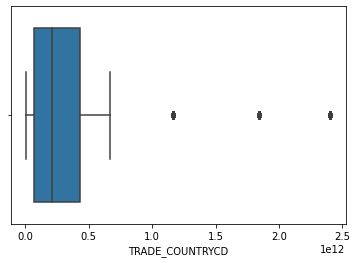

In [14]:
sns.boxplot(data=raw_data, x = raw_data['TRADE_COUNTRYCD'])

### Z-Score
- TRADE_COUNTRYCD 이상치 상세 확인 작업 수행

In [15]:
def find_outlier_z(data):
    threshold = 3
    mean = np.mean(data)
    std = np.std(data)
    z_score = [(y - mean) / std for y in data]
    masks = np.where(np.abs(z_score) > threshold)
    return masks

Outlier_Count_z = Counter(find_outlier_z(Outlier_Check.TRADE_COUNTRYCD)[0])
print("TRADE_COUNTRYCD Oulier 개수: ", sum(Outlier_Count_z.values()))

TRADE_COUNTRYCD Oulier 개수:  994


In [16]:
# TRADE_COUNTRYCD Oulier 값 확인
for i in find_outlier_z(Outlier_Check.TRADE_COUNTRYCD)[0]:
    print(Outlier_Check.TRADE_COUNTRYCD[i:i+1])

9    1843792938795
Name: TRADE_COUNTRYCD, dtype: int64
42    2405276626657
Name: TRADE_COUNTRYCD, dtype: int64
52    1843792938795
Name: TRADE_COUNTRYCD, dtype: int64
84    2405276626657
Name: TRADE_COUNTRYCD, dtype: int64
94    1843792938795
Name: TRADE_COUNTRYCD, dtype: int64
127    2405276626657
Name: TRADE_COUNTRYCD, dtype: int64
137    1843792938795
Name: TRADE_COUNTRYCD, dtype: int64
170    2405276626657
Name: TRADE_COUNTRYCD, dtype: int64
179    1843792938795
Name: TRADE_COUNTRYCD, dtype: int64
212    2405276626657
Name: TRADE_COUNTRYCD, dtype: int64
222    1843792938795
Name: TRADE_COUNTRYCD, dtype: int64
254    2405276626657
Name: TRADE_COUNTRYCD, dtype: int64
264    1843792938795
Name: TRADE_COUNTRYCD, dtype: int64
297    2405276626657
Name: TRADE_COUNTRYCD, dtype: int64
307    1843792938795
Name: TRADE_COUNTRYCD, dtype: int64
339    2405276626657
Name: TRADE_COUNTRYCD, dtype: int64
349    1843792938795
Name: TRADE_COUNTRYCD, dtype: int64
381    2405276626657
Name: TRADE_COUN

Name: TRADE_COUNTRYCD, dtype: int64
13925    1843792938795
Name: TRADE_COUNTRYCD, dtype: int64
13958    2405276626657
Name: TRADE_COUNTRYCD, dtype: int64
13968    1843792938795
Name: TRADE_COUNTRYCD, dtype: int64
14001    2405276626657
Name: TRADE_COUNTRYCD, dtype: int64
14009    1843792938795
Name: TRADE_COUNTRYCD, dtype: int64
14042    2405276626657
Name: TRADE_COUNTRYCD, dtype: int64
14051    1843792938795
Name: TRADE_COUNTRYCD, dtype: int64
14083    2405276626657
Name: TRADE_COUNTRYCD, dtype: int64
14093    1843792938795
Name: TRADE_COUNTRYCD, dtype: int64
14126    2405276626657
Name: TRADE_COUNTRYCD, dtype: int64
14136    1843792938795
Name: TRADE_COUNTRYCD, dtype: int64
14169    2405276626657
Name: TRADE_COUNTRYCD, dtype: int64
14179    1843792938795
Name: TRADE_COUNTRYCD, dtype: int64
14212    2405276626657
Name: TRADE_COUNTRYCD, dtype: int64
14221    1843792938795
Name: TRADE_COUNTRYCD, dtype: int64
14254    2405276626657
Name: TRADE_COUNTRYCD, dtype: int64
14264    18437929387

---

# 2. 데이터 정제 (Data Cleansing)

## 2.1 PA_NUS_FCRF 결측값 처리 [1/4] 

Euro화 사용 국가의 US$ 환율 연평균 데이터 (Domestic Currency per U.S. Dollar, Period Average) 데이터를 통해 결측값 대체

#### 결측값 확인

In [17]:
# raw_data - PA_NUS_FCRF 결측값 확인
r_PA_COUNTRYNM = raw_data[raw_data.PA_NUS_FCRF.isnull()].COUNTRYNM.value_counts()
print('- 국가별 결측치')
print(r_PA_COUNTRYNM)
print('=======================================')

r_PA_HSCD = raw_data[raw_data.PA_NUS_FCRF.isnull()].HSCD.value_counts().nlargest(5)
print('- HS Code별 결측치')
print(r_PA_HSCD)

- 국가별 결측치
Netherlands    500
Germany        500
France         499
Austria        499
Italy          499
Spain          498
Belgium        493
Name: COUNTRYNM, dtype: int64
- HS Code별 결측치
961210    7
852721    7
420212    7
392690    7
330790    7
Name: HSCD, dtype: int64


In [18]:
# submission - PA_NUS_FCRF 결측값 확인
s_PA_COUNTRYNM = submission[submission.PA_NUS_FCRF.isnull()].COUNTRYNM.value_counts()
print('- 국가별 결측치')
print(s_PA_COUNTRYNM)
print('=======================================')

s_PA_HSCD = submission[submission.PA_NUS_FCRF.isnull()].HSCD.value_counts().nlargest(5)
print('- HS Code별 결측치')
print(s_PA_HSCD)

- 국가별 결측치
Netherlands    500
Germany        500
France         499
Austria        499
Italy          499
Spain          498
Belgium        493
Name: COUNTRYNM, dtype: int64
- HS Code별 결측치
961210    7
848130    7
391732    7
420212    7
392690    7
Name: HSCD, dtype: int64


- 결측치 국가는 모두 EU국가 중 유로(EURO)화를 사용한다는 공통점 파악

####  결측값 처리

In [19]:
# 추가 데이터 로드
Ex = pd.read_csv('./data/PA_NUS_FCRF/Exchange_Rates_incl_Effective_Ex_Ra.csv', usecols=[0, 11,12])
Ex.head(5)

,Concept,2017,2018
0,"National Currency per SDR,...",1.19000,1.21000
1,"National Currency per SDR,...",1.23000,1.20000
2,Domestic Currency per U.S....,0.83000,0.87000
3,Domestic Currency per U.S....,0.88521,0.84677
4,Nominal Effective Exchange...,102.65000,108.02000


In [20]:
# 결측값 대체
raw_data['PA_NUS_FCRF'] = raw_data['PA_NUS_FCRF'].replace(np.nan,Ex.at[3,'2017'])
submission['PA_NUS_FCRF'] = submission['PA_NUS_FCRF'].replace(np.nan,Ex.at[3,'2018'])

---

## 2.2 TRADE_HSCD_COUNTRYCD 결측값 처리 [2/4]

- ITC의 Trade Map 통계 데이터를 통해 결측값 대체
- 해당 데이터는 수입 기록이 조회한 모든 연도에 없을 시 품목 자체를 표시하지 않음
- 조회연도 중 한 건이라도 데이터가 존재하고, 그 외 연도에 수입 기록이 없는 경우 '0'으로 표시함

#### 결측값 확인

In [21]:
# raw_data 결측값 확인
r_TRADE_COUNTRYNM = raw_data[raw_data.TRADE_HSCD_COUNTRYCD.isnull()].COUNTRYNM.value_counts()
print('- 국가별 결측치')
print(r_TRADE_COUNTRYNM)
print('=======================================')

r_TRADE_HSCD = raw_data[raw_data.TRADE_HSCD_COUNTRYCD.isnull()].HSCD.value_counts().nlargest(5)
print('- HS Code별 결측치')
print(r_TRADE_HSCD)

- 국가별 결측치
Kuwait                  5
Saudi Arabia            3
Viet Nam                2
Singapore               2
Mexico                  2
Egypt                   2
Philippines             2
United Kingdom          1
China, Hong Kong SAR    1
Iran                    1
Name: COUNTRYNM, dtype: int64
- HS Code별 결측치
382499    6
852852    6
210390    1
600410    1
190230    1
Name: HSCD, dtype: int64


 - 10개 국가에서 결측치 존재

In [22]:
# submission 결측값 확인
s_TRADE_HSCD = submission[submission.TRADE_HSCD_COUNTRYCD.isnull()].HSCD.value_counts()
print('- HS Code별 결측치')
print(s_TRADE_HSCD)
print('=======================================')

s_TRADE_COUNTRYNM = submission[submission.TRADE_HSCD_COUNTRYCD.isnull()].COUNTRYNM.value_counts()
print('- 국가별 결측치')
print(s_TRADE_COUNTRYNM)

- HS Code별 결측치
999999    3
Name: HSCD, dtype: int64
- 국가별 결측치
Guatemala    1
Viet Nam     1
Spain        1
Name: COUNTRYNM, dtype: int64


- 기타 품목인 999999에만 결측치 존재

#### Kuwait

In [23]:
# 추가 데이터 로드
df_Kuwait = pd.read_csv('./data/TRADE_HSCD_COUNTRYCD/Kuwait.csv', dtype={'Code': str},index_col='Code',  usecols=[0, 1])
Kuwait = raw_data[raw_data['COUNTRYNM'] == 'Kuwait']
Kuwait_null = list(set(Kuwait[Kuwait['TRADE_HSCD_COUNTRYCD'].isna()]['HSCD']))

# 결측치 확인
print("Kuwait 결측값 품목 : ", Kuwait_null)
print('===========================================')
try :
    print("Kuwait 결측값 품목 실제 값 : ")
    print(df_Kuwait.loc[Kuwait_null])
except KeyError :
    print("실제로 수입한적 없음")

Kuwait 결측값 품목 :  ['210690', '210390', '190230', '190590', '190219']
Kuwait 결측값 품목 실제 값 : 
        Imported value in 2017
Code                          
210690                  126346
210390                   45737
190230                    1672
190590                   81486
190219                   19965


#### Saudi Arabia

In [24]:
# 추가 데이터 로드
df_Saudi = pd.read_csv('./data/TRADE_HSCD_COUNTRYCD/Saudi_Arabia.csv', dtype={'Code': str},index_col='Code',  usecols=[0, 1])
Saudi = raw_data[raw_data['COUNTRYNM'] == 'Saudi Arabia']
Saudi_null = list(set(Saudi[Saudi['TRADE_HSCD_COUNTRYCD'].isna()]['HSCD']))

# 결측치 확인
print("Saudi Arabia 결측값 품목 : ", Saudi_null)
print('===========================================')
try :
    print("Saudi Arabia 결측값 품목 실제 값 : ")
    print(df_Saudi.loc[Saudi_null])
except KeyError :
    print("실제로 수입한적 없음")

Saudi Arabia 결측값 품목 :  ['852852', '481890', '382499']
Saudi Arabia 결측값 품목 실제 값 : 
실제로 수입한적 없음


#### Mexico

In [25]:
# 추가 데이터 로드
df_Mexico = pd.read_csv('./data/TRADE_HSCD_COUNTRYCD/Mexico.csv', dtype={'Code': str},index_col='Code',  usecols=[0, 1], )
Mexico = raw_data[raw_data['COUNTRYNM'] == 'Mexico']
Mexico_null = list(set(Mexico[Mexico['TRADE_HSCD_COUNTRYCD'].isna()]['HSCD']))

# 결측치 확인
print("Mexico 결측값 품목 : ", Mexico_null)
print('===========================================')
try:
    print("Mexico 결측값 품목 실제 값 : ")
    print(df_Mexico.loc[Mexico_null])
except KeyError :
        print("실제로 수입한적 없음")

Mexico 결측값 품목 :  ['852852', '382499']
Mexico 결측값 품목 실제 값 : 
실제로 수입한적 없음


#### Singapore

In [26]:
# 추가 데이터 로드
df_Singapore = pd.read_csv('./data/TRADE_HSCD_COUNTRYCD/Singapore.csv', dtype={'Code': str},index_col='Code',  usecols=[0, 1], )
Singapore = raw_data[raw_data['COUNTRYNM'] == 'Singapore']
Singapore_null = list(set(Singapore[Singapore['TRADE_HSCD_COUNTRYCD'].isna()]['HSCD']))

# 결측치 확인
print("Mexico 결측값 품목 : ", Singapore_null)
print('===========================================')
try:
    print("Singapore 결측값 품목 실제값 : ")
    print(df_Singapore.loc[Singapore_null])
except KeyError :
        print("실제로 수입한적 없음")

Mexico 결측값 품목 :  ['852852', '382499']
Singapore 결측값 품목 실제값 : 
        Imported value in 2017
Code                          
852852                       0
382499                       0


#### Egypt

In [27]:
# 추가 데이터 로드
df_Egypt = pd.read_csv('./data/TRADE_HSCD_COUNTRYCD/Egypt.csv', dtype={'Code': str},index_col='Code',  usecols=[0, 1], )
Egypt = raw_data[raw_data['COUNTRYNM'] == 'Egypt']
Egypt_null = list(set(Egypt[Egypt['TRADE_HSCD_COUNTRYCD'].isna()]['HSCD']))

# 결측치 확인
print("Egypt 결측값 품목 : ", Egypt_null)
print('===========================================')
try:
    print("Egypt 결측값 품목 실제값 : ")
    print(df_Egypt.loc[Egypt_null])
except KeyError :
        print("실제로 수입한적 없음")

Egypt 결측값 품목 :  ['852852', '382499']
Egypt 결측값 품목 실제값 : 
실제로 수입한적 없음


#### Philippines

In [28]:
# 추가 데이터 로드
df_Philippines = pd.read_csv('./data/TRADE_HSCD_COUNTRYCD/Philippines.csv', dtype={'Code': str},index_col='Code',  usecols=[0, 1], )
Philippines = raw_data[raw_data['COUNTRYNM'] == 'Philippines']
Philippines_null = list(set(Philippines[Philippines['TRADE_HSCD_COUNTRYCD'].isna()]['HSCD']))

# 결측치 확인
print("Philippines 결측값 품목 : ", Philippines_null)
print('===========================================')
try:
    print("Philippines 결측값 품목 실제값 : ")
    print(df_Philippines.loc[Philippines_null])
except KeyError :
        print("실제로 수입한적 없음")

Philippines 결측값 품목 :  ['852852', '382499']
Philippines 결측값 품목 실제값 : 
실제로 수입한적 없음


#### Viet Nam

In [29]:
# 추가 데이터 로드
df_viet = pd.read_csv('./data/TRADE_HSCD_COUNTRYCD/Viet_Nam.csv', dtype={'Code': str},index_col='Code',  usecols=[0, 1], )
viet = raw_data[raw_data['COUNTRYNM'] == 'Viet Nam']
viet_null = list(set(viet[viet['TRADE_HSCD_COUNTRYCD'].isna()]['HSCD']))

# 결측치 확인
print("Viet Nam 결측값 품목 : ", viet_null)
print('===========================================')
try:
    print("Viet Nam 결측값 품목 실제값 : ")
    print(df_viet.loc[viet_null])
except KeyError :
        print("실제로 수입한적 없음")

Viet Nam 결측값 품목 :  ['852852', '382499']
Viet Nam 결측값 품목 실제값 : 
        Imported value in 2017
Code                          
852852                       0
382499                       0


#### Iran

In [30]:
# 추가 데이터 로드
df_Iran = pd.read_csv('./data/TRADE_HSCD_COUNTRYCD/Iran.csv', dtype={'Code': str},index_col='Code',  usecols=[0, 1], )
Iran = raw_data[raw_data['COUNTRYNM'] == 'Iran']
Iran_null = list(set(Iran[Iran['TRADE_HSCD_COUNTRYCD'].isna()]['HSCD']))

# 결측치 확인
print("Iran 결측값 품목 : ", Iran_null)
print('===========================================')
try:
    print("Iran 결측값 품목 실제값 : ")
    print(df_Iran.loc[Iran_null])
except KeyError :
        print("실제로 수입한적 없음")

Iran 결측값 품목 :  ['600410']
Iran 결측값 품목 실제값 : 
        Imported value in 2017
Code                          
600410                       0


#### Hong Kong

In [31]:
df_HongKong = pd.read_csv('./data/TRADE_HSCD_COUNTRYCD/Hong_Kong.csv', dtype={'Code': str},index_col='Code',  usecols=[0, 1], )

HongKong = raw_data[raw_data['COUNTRYNM'] == 'China, Hong Kong SAR']
HongKong_null = list(set(HongKong[HongKong['TRADE_HSCD_COUNTRYCD'].isna()]['HSCD']))

# 결측치 확인
print("Hong Kong 결측값 품목 : ", HongKong_null)
print('===========================================')
try:
    print("Hong Kong 결측값 품목 실제값 : ")
    print(df_HongKong.loc[HongKong_null])
except KeyError :
        print("실제로 수입한적 없음")

Hong Kong 결측값 품목 :  ['540769']
Hong Kong 결측값 품목 실제값 : 
        Imported value in 2017
Code                          
540769                       0


#### 결측값 처리

In [32]:
# 결측값 처리 [Kuwait]
raw_data.loc[20, 'TRADE_HSCD_COUNTRYCD'] = 81486000
raw_data.loc[62, 'TRADE_HSCD_COUNTRYCD'] = 1672000
raw_data.loc[105, 'TRADE_HSCD_COUNTRYCD'] = 19965000
raw_data.loc[486, 'TRADE_HSCD_COUNTRYCD'] = 126346000
raw_data.loc[529, 'TRADE_HSCD_COUNTRYCD'] = 45737000

In [33]:
# 결측치 처리 (Saudi Ariaba ~ Hong Kong)
raw_data['TRADE_HSCD_COUNTRYCD'] = raw_data['TRADE_HSCD_COUNTRYCD'].replace(np.nan,1e-05)
submission['TRADE_HSCD_COUNTRYCD'] = submission['TRADE_HSCD_COUNTRYCD'].replace(np.nan,1e-05)

---

## 2.3 TARIFF_AVG 결측값 처리 [3/4]

- 해당 변수에 대한 결측치는 HSCD(품목코드)와 국가명(COUNTRYNM)을 이용하여 결측치를 채우는 방안을 제시
- (해당 품목을 구매한 국가들의 평균 + 해당국가의 관세 평균) / 2

#### 결측값 확인

In [34]:
# raw_data 결측값 확인
r_TARIFF_AVG = raw_data[raw_data.TARIFF_AVG.isnull()].HSCD.value_counts().nlargest(5)
print('- HS Code별 결측치')
print(r_TARIFF_AVG)
print('=======================================')

r_TARIFF_AVG = raw_data[raw_data.TARIFF_AVG.isnull()].COUNTRYNM.value_counts().nlargest(5)
print('- 국가별 결측치')
print(r_TARIFF_AVG)

- HS Code별 결측치
382499    43
852852    43
999999    36
903290     1
903300     1
Name: HSCD, dtype: int64
- 국가별 결측치
New Zealand    8
Egypt          4
Turkey         3
USA            3
Switzerland    3
Name: COUNTRYNM, dtype: int64


In [35]:
# submission 결측값 확인
s_TARIFF_AVG = submission[submission.TARIFF_AVG.isnull()].COUNTRYNM.value_counts().nlargest(5)
print('- 국가별 결측치')
print(s_TARIFF_AVG)
print('=======================================')
s_TARIFF_AVG = submission[submission.TARIFF_AVG.isnull()].HSCD.value_counts().nlargest(5)
print('- HS Code별 결측치')
print(s_TARIFF_AVG)

- 국가별 결측치
USA                     500
Iran                      5
United Kingdom            4
Egypt                     4
China, Hong Kong SAR      4
Name: COUNTRYNM, dtype: int64
- HS Code별 결측치
382499    43
852852    43
999999    36
420232     2
600410     2
Name: HSCD, dtype: int64


#### 결측값 처리

In [36]:
def TARIFF_AVG_MISS(data):
    df = data.copy()
    
    # 1. 해당 품목을 구매한 국가들의 평균 관세
    HSCD_AVG = df[df['TARIFF_AVG'].notna()].groupby('HSCD')['TARIFF_AVG'].mean()

    # 2. 결측 해당 국가의 평균 관세
    CTRY_AVG = df[df['COUNTRYNM'].notna()].groupby('COUNTRYNM')['TARIFF_AVG'].mean()

    # 3. 우리가 구해야할 데이터프레임
    NA_COl = df.loc[df[df['TARIFF_AVG'].isna()].index,['HSCD','COUNTRYNM']]

    # 4. 계산
    HSCD_AVG_R = NA_COl.merge(HSCD_AVG, on = 'HSCD', how = 'left').fillna(0)
    CTRY_AVG_R = NA_COl.merge(CTRY_AVG, on = 'COUNTRYNM', how = 'left').fillna(0)
    result = (HSCD_AVG_R['TARIFF_AVG'] + CTRY_AVG_R['TARIFF_AVG']) / 2

    # 5. 결측 대입
    df.loc[df[df['TARIFF_AVG'].isna()].index,'TARIFF_AVG'] = result.values
    
    return df

# 결측값 대체
raw_data = TARIFF_AVG_MISS(raw_data)
submission = TARIFF_AVG_MISS(submission)

---

## 2.4 SNDIST 결측값 처리 [4/4]

- 해당 변수에 대한 결측치는 추가 데이터를 확인하여 해당 국가가 해당 품목을 수입한 국가들 간의 평균 거리를 구하고자 함.
- 예를 들어 쿠웨이트가 Z품목을 미국, 프랑스, 인도에서만 수입했다면 SNDIST 값은 다음과 같은 식을 이용함.
- 쿠웨이트와 미국간의 거리 = A, 쿠웨이트와 프랑스 간의 거리 = B, 쿠웨이트와 인도와의 거리 = C
- SNDIST = (A+B+C)/3

In [37]:
# 추가 데이터 로드
SNDIST_data_dist = pd.io.stata.read_stata('./data/SNDIST/dist_cepii.dta')
SNDIST_data_geo = pd.io.stata.read_stata('./data/SNDIST/geo_cepii.dta')

# 추가 데이터 전처리 : iso3 국가명이 일치하지 않아 수정
SNDIST_data_geo['country'] = SNDIST_data_geo['country'].replace('Hong Kong','China, Hong Kong SAR')
SNDIST_data_geo['country'] = SNDIST_data_geo['country'].replace('Belgium and Luxembourg','Belgium')
SNDIST_data_geo['country'] = SNDIST_data_geo['country'].replace('Burma','Myanmar')
SNDIST_data_geo['country'] = SNDIST_data_geo['country'].replace('Czech Republic','Czechia')
SNDIST_data_geo['country'] = SNDIST_data_geo['country'].replace('Kazakstan','Kazakhstan')
SNDIST_data_geo['country'] = SNDIST_data_geo['country'].replace('United States of America','USA')

#### 결측값 확인

In [38]:
# 1. SNDIST이 결측값인 해당 품목 조회
def SNDIST_CHECK_MISS(data):
    df = data.copy()
    
    # 1) 결측 품목코드, 국가명, 국가 갯수 확인
    HSCD_code = df[df['SNDIST'].isna()]['HSCD'].to_list() # 22품목코드
    print('SNDIST가 결측인 품목코드 갯수 : ',len(HSCD_code), HSCD_code[:5])

    NA_col = list(set(df[df['SNDIST'].isna()]['COUNTRYNM'])) # 11개국
    print('SNDIST가 결측인 국가명 갯수 : ',len(NA_col),NA_col[:5])

    target_contry = df[df['HSCD'] == HSCD_code[0]].COUNTRYNM.to_list() # for문으로 돌려봐야함 
    print('해당 품목의 타겟 국가 갯수 : ',len(target_contry), target_contry[:5])
    
    # 2) 국가명 불일치 확인
    check_name = df[df['HSCD'] == HSCD_code[0]]['COUNTRYNM']
    print(check_name[(check_name.isin(SNDIST_data_geo['country']) == False).values])
    
SNDIST_CHECK_MISS(raw_data)
print('=======================================================================================================')
SNDIST_CHECK_MISS(submission)

SNDIST가 결측인 품목코드 갯수 :  22 ['190590', '190230', '190219', '540769', '210690']
SNDIST가 결측인 국가명 갯수 :  11 ['Australia', 'United Kingdom', 'Viet Nam', 'Mexico', 'Iran']
해당 품목의 타겟 국가 갯수 :  43 ['Algeria', 'Australia', 'Austria', 'Belgium', 'Brazil']
Series([], Name: COUNTRYNM, dtype: object)
SNDIST가 결측인 품목코드 갯수 :  3 ['999999', '999999', '999999']
SNDIST가 결측인 국가명 갯수 :  3 ['Guatemala', 'Viet Nam', 'Spain']
해당 품목의 타겟 국가 갯수 :  36 ['Australia', 'Austria', 'Belgium', 'Myanmar', 'Canada']
Series([], Name: COUNTRYNM, dtype: object)


#### 결측값 처리

In [39]:
def SNDIST_missing(data):
    df = data.copy()
    
    na_data = df[df.SNDIST.isna()][['HSCD','COUNTRYNM','SNDIST']]
    HSCD_index = na_data['HSCD'].reset_index(drop = True)

    HSCD_code = df[df['SNDIST'].isna()]['HSCD'].to_list()
    NA_col = list(set(df[df['SNDIST'].isna()]['COUNTRYNM']))
    geo_name = SNDIST_data_geo[SNDIST_data_geo['country'].isin(NA_col)][['country','iso3']].drop_duplicates()

    # HSCD품목별 국가에 대한 거리 생성
    for i in range(len(na_data)):
        target_contry = df[df['HSCD'] == HSCD_code[i]].COUNTRYNM.to_list()    
        iso3_name = SNDIST_data_geo[SNDIST_data_geo['country'].isin(target_contry)][['country','iso3']].drop_duplicates()
        iso_o = geo_name['iso3'].to_list()
        iso_d = iso3_name['iso3'].to_list()

        # 해당 품목을 수입한 국가들간의 평균 거리 계산
        num = df[df['HSCD'] == na_data.iloc[i,0]].COUNTRYNM.to_list()
        cty = SNDIST_data_geo[SNDIST_data_geo['country'].isin(num)][['country','iso3']].drop_duplicates() 
        iso3_1 = SNDIST_data_geo[SNDIST_data_geo['country'].isin([na_data.iloc[i,1]])][['country','iso3']].drop_duplicates()

        # 기준 국가  
        CD_name = SNDIST_data_dist[SNDIST_data_dist['iso_o'] == iso3_1['iso3'].to_list()[0]][['iso_o','iso_d','dist']]
        # 상대 국가
        result = CD_name[CD_name['iso_d'].isin(cty['iso3'].to_list())]
        # 평균 값
        na_data.iloc[i,2] = result['dist'].mean()
        
    result = df.combine_first(pd.DataFrame(na_data['SNDIST']))
    return result

# 결측값 대체
raw_data = SNDIST_missing(raw_data)
submission = SNDIST_missing(submission)

---

# 3. 파생변수 (Derived Variable) 정의 및 생성

## 3.1 IMPORT_COST (수입 비용 부담도)

> IMPORT COST = KMDIST*(Oil Basket Price/GDP per Capita)
- 세계 유가(Oil Basket Price)를 해당 국가의 1인당 GDP (GDP per Capita)로 각 국가의 실질 유가 부담 지수(OBP_Capita)를 도출,<br>
이를 기반으로 한국과의 거리(KMDIST)에 따른 원유 사용량을 통해 수입 비용을 추출

### 3.1.1) OBP (Oil Basket Price)

- OPEC의 Oil Basket Price(OBP) 데이터 확보
- OBP : OPEC 회원국들이 생산하는 7개 대표 유종(油種)의 가격을 가중평균한 원유가격, OPEC는 이 가격을 국제유가의 지표로 삼고 있음
- OBP Daily Archive xml 데이터에서 2017, 2018년 Oil Baseket Price 연간 평균을 도출

In [40]:
import xmltodict
import json

# 추가 데이터 로드
xml = open('./data/IMPORT_COST/basketDayArchives.xml').read()
dat = json.loads(json.dumps(xmltodict.parse(xml)))
print(dat)

{'Basket': {'@xmlns': 'http://tempuri.org/basketDayArchives.xsd', 'BasketList': [{'@data': '2003-01-02', '@val': '30.05'}, {'@data': '2003-01-03', '@val': '30.83'}, {'@data': '2003-01-06', '@val': '30.71'}, {'@data': '2003-01-07', '@val': '29.72'}, {'@data': '2003-01-08', '@val': '28.86'}, {'@data': '2003-01-09', '@val': '29.51'}, {'@data': '2003-01-10', '@val': '29.82'}, {'@data': '2003-01-13', '@val': '29.82'}, {'@data': '2003-01-14', '@val': '30.21'}, {'@data': '2003-01-15', '@val': '30.66'}, {'@data': '2003-01-16', '@val': '30.87'}, {'@data': '2003-01-17', '@val': '31.02'}, {'@data': '2003-01-20', '@val': '31.21'}, {'@data': '2003-01-21', '@val': '30.90'}, {'@data': '2003-01-22', '@val': '30.89'}, {'@data': '2003-01-23', '@val': '30.18'}, {'@data': '2003-01-24', '@val': '30.56'}, {'@data': '2003-01-27', '@val': '30.16'}, {'@data': '2003-01-28', '@val': '29.83'}, {'@data': '2003-01-29', '@val': '30.30'}, {'@data': '2003-01-30', '@val': '30.58'}, {'@data': '2003-01-31', '@val': '30.7

In [41]:
# 추가 데이터 전처리
Oil_price = pd.json_normalize(dat['Basket'],
                      record_path = 'BasketList')
Oil_price.rename(columns = {'@data':'date', '@val':'val'}, inplace = True)

Oil_2017 = Oil_price.loc[Oil_price.date.str.contains('2017'), :].copy()
Oil_2018 = Oil_price.loc[Oil_price.date.str.contains('2018'), :].copy()

Oil_2017['val'] = pd.to_numeric(Oil_2017['val'])
Oil_2018['val'] = pd.to_numeric(Oil_2018['val'])


# OBP의 가격 단위는 $ per barrel이므로 $ per liter로 변환
OBP_2017 = round(Oil_2017['val'].mean()/158.9, 4)
OBP_2018 = round(Oil_2018['val'].mean()/158.9, 4)

### 3.1.2) GDP per Capita (1인당 국내 총생산)

- WorldBank DataBank의 World Development Indicators 지표에서 데이터 확보
- OBP를 GDP per Capita로 나누어 실질 유가부담 지수(OBP_Captia)를 추출

In [42]:
# 추가 데이터 로드
Capita_2017 = pd.read_csv('./data/IMPORT_COST/World_Development_Indicators.csv', usecols =[0,2], dtype={'2017': float})
Capita_2018 = pd.read_csv('./data/IMPORT_COST/World_Development_Indicators.csv', usecols =[0,3], dtype={'2018': float})

In [43]:
# 추가 데이터 전처리
Capita_2017.rename(columns = {'Country Name':'COUNTRYNM', '2017':'GDP_Capita'}, inplace = True)
Capita_2017['COUNTRYNM'] = Capita_2017['COUNTRYNM'].replace('Hong Kong SAR, China','China, Hong Kong SAR')
Capita_2017['COUNTRYNM'] = Capita_2017['COUNTRYNM'].replace('Vietnam','Viet Nam')
Capita_2017['COUNTRYNM'] = Capita_2017['COUNTRYNM'].replace('Egypt, Arab Rep.','Egypt')
Capita_2017['COUNTRYNM'] = Capita_2017['COUNTRYNM'].replace('Czech Republic','Czechia')
Capita_2017['COUNTRYNM'] = Capita_2017['COUNTRYNM'].replace('Iran, Islamic Rep.','Iran')
Capita_2017['COUNTRYNM'] = Capita_2017['COUNTRYNM'].replace('United States','USA')

Capita_2018.rename(columns = {'Country Name':'COUNTRYNM', '2018':'GDP_Capita'}, inplace = True)
Capita_2018['COUNTRYNM'] = Capita_2018['COUNTRYNM'].replace('Hong Kong SAR, China','China, Hong Kong SAR')
Capita_2018['COUNTRYNM'] = Capita_2018['COUNTRYNM'].replace('Vietnam','Viet Nam')
Capita_2018['COUNTRYNM'] = Capita_2018['COUNTRYNM'].replace('Egypt, Arab Rep.','Egypt')
Capita_2018['COUNTRYNM'] = Capita_2018['COUNTRYNM'].replace('Czech Republic','Czechia')
Capita_2018['COUNTRYNM'] = Capita_2018['COUNTRYNM'].replace('Iran, Islamic Rep.','Iran')
Capita_2018['COUNTRYNM'] = Capita_2018['COUNTRYNM'].replace('United States','USA')

In [44]:
# 실질 유가부담 지수(OBP_Capita) 도출
Capita_2017['OBP_Capita'] = OBP_2017/Capita_2017['GDP_Capita']
Capita_2018['OBP_Capita'] = OBP_2018/Capita_2018['GDP_Capita']
Capita_2017.head(5)

,COUNTRYNM,GDP_Capita,OBP_Capita
0,Afghanistan,519.88891,0.00063
1,Albania,4531.02081,0.00007
2,Algeria,4109.70344,0.00008
3,American Samoa,11003.82976,0.00003
4,Andorra,38964.90448,0.00001


### 3.1.3 IMPORT_COST 파생변수 생성

In [45]:
# 원본 데이터 결합
raw_data = pd.merge(raw_data, Capita_2017, on='COUNTRYNM', how='left')
submission = pd.merge(submission, Capita_2018, on='COUNTRYNM', how='left')


# 수입 비용 부담도 (IMPORT_COST) 도출
raw_data['IMPORT_COST'] = raw_data['KMDIST']* raw_data['OBP_Capita']
submission['IMPORT_COST'] = submission['KMDIST']* submission['OBP_Capita']

---

## 3.2 TOB_HSCD (HSCODE 별 무역수지)

> TOB (Trade of Balance) = Export Value - Import Value [by AG2]
- Trade of Balance는 무역 수지를 나타내며 수출액과 수입액의 차이로 계산
- TOB_HSCD 파생변수의 경우 HS Code 2품목 (AG2)별로 구분된 국가별 무역수지를 의미

### 3.2.1) AG2 (All-2-digit HS commodities)

- UN Comtrade의 국가들의 AG2 별 전세계 대상 수출액, 수입액 데이터 확보
- AG2는 HSCD 앞 2자리를 의미하며, 부(Section)를 표현

In [46]:
# 추가 데이터 로드
path = './data/TOB_HSCD/'

forders = os.listdir(path)
forders = [file for file in forders if file.endswith("2017.csv")]

AG2_2017 = pd.DataFrame()
for files in forders:
    df = pd.read_csv(path + files, dtype={'Commodity Code':str})
    AG2_2017 = pd.concat([AG2_2017, df])


forders = os.listdir(path)
forders = [file for file in forders if file.endswith("2018.csv")]

AG2_2018 = pd.DataFrame()
for files in forders:
    df = pd.read_csv(path + files, dtype={'Commodity Code':str})
    AG2_2018 = pd.concat([AG2_2018, df])

In [47]:
# 추가 데이터 전처리
AG2_2017['Commodity Code'] = AG2_2017['Commodity Code'].str.zfill(width=2)
AG2_2017 = AG2_2017.iloc[:,[7,9,21,31]]

AG2_2018['Commodity Code'] = AG2_2018['Commodity Code'].str.zfill(width=2)
AG2_2018 = AG2_2018.iloc[:,[7,9,21,31]]

In [48]:
# 수입액 수출액 row 분리 후, column 결합
IMP_AG2_2017 = AG2_2017[AG2_2017['Trade Flow'] == 'Import'].sort_values(by=['Reporter','Commodity Code'])
EXP_AG2_2017 = AG2_2017[AG2_2017['Trade Flow'] == 'Export'].sort_values(by=['Reporter','Commodity Code'])
TOB_HSCD_2017 = pd.merge(EXP_AG2_2017, IMP_AG2_2017, how ='outer', on =['Reporter','Commodity Code'], suffixes=('_EX', '_IM'),)

IMP_AG2_2018 = AG2_2018[AG2_2018['Trade Flow'] == 'Import'].sort_values(by=['Reporter','Commodity Code'])
EXP_AG2_2018 = AG2_2018[AG2_2018['Trade Flow'] == 'Export'].sort_values(by=['Reporter','Commodity Code'])
TOB_HSCD_2018 = pd.merge(EXP_AG2_2018, IMP_AG2_2018, how ='outer', on =['Reporter','Commodity Code'], suffixes=('_EX', '_IM'),)

### 3.2.2) TOB_HSCD 파생변수 생성

In [49]:
# TOB_HSCD 도출
TOB_HSCD_2017.fillna(0)
TOB_HSCD_2017 = TOB_HSCD_2017.sort_values(by=['Reporter','Commodity Code'])
TOB_HSCD_2017['Trade Value (US$)_EX'] = TOB_HSCD_2017['Trade Value (US$)_EX'].replace(np.nan,0)
TOB_HSCD_2017['Trade Value (US$)_IM'] = TOB_HSCD_2017['Trade Value (US$)_IM'].replace(np.nan,0)
TOB_HSCD_2017['TOB_HSCD'] = TOB_HSCD_2017['Trade Value (US$)_EX'] - TOB_HSCD_2017['Trade Value (US$)_IM']

TOB_HSCD_2018.fillna(0)
TOB_HSCD_2018 = TOB_HSCD_2018.sort_values(by=['Reporter','Commodity Code'])
TOB_HSCD_2018['Trade Value (US$)_EX'] = TOB_HSCD_2018['Trade Value (US$)_EX'].replace(np.nan,0)
TOB_HSCD_2018['Trade Value (US$)_IM'] = TOB_HSCD_2018['Trade Value (US$)_IM'].replace(np.nan,0)
TOB_HSCD_2018['TOB_HSCD'] = TOB_HSCD_2018['Trade Value (US$)_EX'] - TOB_HSCD_2018['Trade Value (US$)_IM']

In [50]:
# 원본 데이터 결합
TOB_HSCD_2017 = TOB_HSCD_2017.iloc[:,[1,2,6]]
TOB_HSCD_2017.rename(columns = {"Reporter":"COUNTRYNM","Commodity Code":"AG2"}, inplace=True)

TOB_HSCD_2018 = TOB_HSCD_2018.iloc[:,[1,2,6]]
TOB_HSCD_2018.rename(columns = {"Reporter":"COUNTRYNM","Commodity Code":"AG2"}, inplace=True)

raw_data['AG2'] = raw_data['HSCD'].str[:2]
raw_data = pd.merge(raw_data,TOB_HSCD_2017, how ='left', on = ['COUNTRYNM','AG2'])
raw_data = raw_data.drop(columns=['AG2'])

submission['AG2'] = submission['HSCD'].str[:2]
submission = pd.merge(submission,TOB_HSCD_2018, how ='left', on = ['COUNTRYNM','AG2'])
submission = submission.drop(columns=['AG2'])

In [51]:
# 품목 999999 결측값 확인
raw_data.loc[raw_data['TOB_HSCD'].isna(), ['COUNTRYNM','HSCD','TOB_HSCD']]

,COUNTRYNM,HSCD,TOB_HSCD
6399,Chile,999999,NaN
6403,Guatemala,999999,NaN
6424,Switzerland,999999,NaN
6427,Egypt,999999,NaN


In [52]:
submission.loc[submission['TOB_HSCD'].isna(), ['COUNTRYNM','HSCD','TOB_HSCD']]

,COUNTRYNM,HSCD,TOB_HSCD
4710,Chile,999999,NaN
4714,Guatemala,999999,NaN
4735,Switzerland,999999,NaN
4738,Egypt,999999,NaN


---

## 3.3 OVERSEA_DPNDCY (해외 의존도)

>OVERSEA_DPENDCY = Import Value - Export Value
- 해외 의존도는 해당 국가에서 해당 품목을 얼마나 해외 수입에 의존하고 있는지를 의미
- 각 국가 신성질별(Raw Materials, Capital Goods, Consumer Goods) 수입액에서 수출액을 뺴는것으로 계산
- Export & Import Share : 각 국가의 신성질 분류 별 총 상품 무역 (수출, 수입)의 점유율 데이터

### 3.3.1) 신성질별 분류 데이터

- 관세청이 HS 품목 분류를 기준으로 소비재(Consumer Goods), 원자재(Raw Materials), 자본재(Capital Goods)를 대분류로 하여 제공하는 무역통계
- HS 신성질별 연계표에 따르면 각 HS 품목은 대분류, 중분류, 소분류로 구분

In [53]:
# 신성질 분류 데이터 정제
HS = pd.read_excel('./data/HSCode/HSCode.xlsx', usecols = [1,6,8,10], dtype = str) 
HS['HS CODE 10'] = HS['HS CODE 10'].str.slice_replace(start=6, stop=10)
HS.rename(columns = {'HS CODE 10' : 'HSCD','대분류명':'Category_L','중분류명':'Category_M','소분류명':'Category_S'}, inplace = True)
HS.drop_duplicates(['HSCD'], keep='first',inplace = True)

# 원본 데이터 결합
raw_data = pd.merge(raw_data, HS, on='HSCD', how='left')
submission = pd.merge(submission, HS, on='HSCD', how='left')

print('학습 데이터 신성질별 분포 :') 
print(raw_data.groupby(['Category_L']).size())

학습 데이터 신성질별 분포 :
Category_L
소비재     5231
원자재     3684
자본재    12238
dtype: int64


In [54]:
HS.head(5)

,HSCD,Category_L,Category_M,Category_S
0,010121,소비재,직접소비재,축산물
2,010129,소비재,직접소비재,축산물
4,010130,소비재,직접소비재,축산물
6,010190,소비재,직접소비재,축산물
7,010221,소비재,직접소비재,축산물


### 3.3.2) DEPENDENCY

- World Integrated Trade Solution의 신성질 분류(원자재, 자본재, 소비재) 별 수출입 데이터 확보
- {수출액 - 수입액}인 무역수지(ToD)와 다르게, {수입액 - 수출액}으로 품목의 해외 의존도 판별

In [55]:
# 추가 데이터 로드
path = './data/PRTS_VALUE/'

forders = os.listdir(path)
forders = [file for file in forders if file.endswith("2017.xlsx")]

PRTS_2017 = pd.DataFrame()
for files in forders:
    df = pd.read_excel(path + files)
    PRTS_2017 = pd.concat([PRTS_2017, df])


forders = os.listdir(path)
forders = [file for file in forders if file.endswith("2018.xlsx")]

PRTS_2018 = pd.DataFrame()
for files in forders:
    df = pd.read_excel(path + files)
    PRTS_2018 = pd.concat([PRTS_2018, df])

In [56]:
# 추가 데이터 전처리
PRTS_2017 = PRTS_2017.iloc[:,[1,4,5,6,7,8]]
PRTS_2017['Partner Name'] = PRTS_2017['Partner Name'].replace('Hong Kong, China','China, Hong Kong SAR')
PRTS_2017['Partner Name'] = PRTS_2017['Partner Name'].replace('Vietnam','Viet Nam')
PRTS_2017['Partner Name'] = PRTS_2017['Partner Name'].replace('Egypt, Arab Rep.','Egypt')
PRTS_2017['Partner Name'] = PRTS_2017['Partner Name'].replace('Czech Republic','Czechia')
PRTS_2017['Partner Name'] = PRTS_2017['Partner Name'].replace('Iran, Islamic Rep.','Iran')
PRTS_2017['Partner Name'] = PRTS_2017['Partner Name'].replace('United States','USA')

PRTS_2018 = PRTS_2018.iloc[:,[1,4,5,6,7,8]]
PRTS_2018['Partner Name'] = PRTS_2018['Partner Name'].replace('Hong Kong, China','China, Hong Kong SAR')
PRTS_2018['Partner Name'] = PRTS_2018['Partner Name'].replace('Vietnam','Viet Nam')
PRTS_2018['Partner Name'] = PRTS_2018['Partner Name'].replace('Egypt, Arab Rep.','Egypt')
PRTS_2018['Partner Name'] = PRTS_2018['Partner Name'].replace('Czech Republic','Czechia')
PRTS_2018['Partner Name'] = PRTS_2018['Partner Name'].replace('Iran, Islamic Rep.','Iran')
PRTS_2018['Partner Name'] = PRTS_2018['Partner Name'].replace('United States','USA')

### 3.3.3) OVERSEA_DPNDCY 파생변수 생성

In [57]:
PRTS_2017['OVERSEA_DPNDCY'] = PRTS_2017['Import (US$ Thousand)'] - PRTS_2017['Export (US$ Thousand)']
PRTS_2018['OVERSEA_DPNDCY'] = PRTS_2018['Import (US$ Thousand)'] - PRTS_2018['Export (US$ Thousand)']

In [58]:
PRTS_2017.replace({'Capital goods':'자본재','Raw materials':'원자재','Consumer goods':'소비재'}, inplace = True)
PRTS_2017.rename(columns = {'Partner Name':'COUNTRYNM','Product Group':'Category_L','Export Product Share (%)':'Export_Product_Share','Import Product Share (%)':'Import_Product_Share'}, inplace = True)
DPNDCY_2017 = PRTS_2017.iloc[:,[0,1,4,5,6]]

PRTS_2018.replace({'Capital goods':'자본재','Raw materials':'원자재','Consumer goods':'소비재'}, inplace = True)
PRTS_2018.rename(columns = {'Partner Name':'COUNTRYNM','Product Group':'Category_L','Export Product Share (%)':'Export_Product_Share','Import Product Share (%)':'Import_Product_Share'}, inplace = True)
DPNDCY_2018 = PRTS_2018.iloc[:,[0,1,4,5,6]]

In [59]:
DPNDCY_2017.head(5)

,COUNTRYNM,Category_L,Export_Product_Share,Import_Product_Share,OVERSEA_DPNDCY
0,Aruba,자본재,10.88000,33.70000,-110108.02000
1,Afghanistan,자본재,26.89000,1.52000,-3023261.03000
2,Angola,자본재,35.75000,1.07000,-5611797.04000
3,Anguila,자본재,15.88000,27.82000,-15145.15000
4,Albania,자본재,16.62000,4.79000,-1240032.73000


In [60]:
# 원본 데이터 결합
raw_data = pd.merge(raw_data, DPNDCY_2017, how = 'left', on =['COUNTRYNM','Category_L'])
submission = pd.merge(submission, DPNDCY_2018, how = 'left', on =['COUNTRYNM','Category_L'])

---

## 3.4 IMPORT_TENDENCY (수입 증감도)

> IMPORT_TENDENCY = Import Value (N) year – Import Value (N-1) year
- 수입 증감도는 같은 신성질 분류 별 품목에 대해 수입액이 얼마나 증감했는지를 알아보는 파생변수
- 해당 년도 신분류 별 수입액에서 그 전년도 수입액을 빼는 것으로 계산

### 3.4.1) TENDENCY

In [61]:
# 추가 데이터 로드
path = './data/PRTS_VALUE/'

forders = os.listdir(path)
forders = [file for file in forders if file.endswith("2016.xlsx")]

IMP_2016 = pd.DataFrame()

for files in forders:
    df = pd.read_excel(path + files)
    IMP_2016 = pd.concat([IMP_2016, df])

In [62]:
# 추가 데이터 전처리
IMP_2016 = IMP_2016.iloc[:,[1,4,6]]
IMP_2016['Partner Name'] = IMP_2016['Partner Name'].replace('Hong Kong, China','China, Hong Kong SAR')
IMP_2016['Partner Name'] = IMP_2016['Partner Name'].replace('Vietnam','Viet Nam')
IMP_2016['Partner Name'] = IMP_2016['Partner Name'].replace('Egypt, Arab Rep.','Egypt')
IMP_2016['Partner Name'] = IMP_2016['Partner Name'].replace('Czech Republic','Czechia')
IMP_2016['Partner Name'] = IMP_2016['Partner Name'].replace('Iran, Islamic Rep.','Iran')
IMP_2016['Partner Name'] = IMP_2016['Partner Name'].replace('United States','USA')
IMP_2016.replace({'Capital goods':'자본재','Raw materials':'원자재','Consumer goods':'소비재'}, inplace = True)
IMP_2016.rename(columns = {'Partner Name':'COUNTRYNM','Product Group':'Category_L','Export Product Share (%)':'Export_Product_Share'}, inplace = True)

IMP_2017 = PRTS_2017.iloc[:,[0,1,3]]
IMP_2018 = PRTS_2018.iloc[:,[0,1,3]]

In [63]:
IMP_2016.replace({'Capital goods':'자본재','Raw materials':'원자재','Consumer goods':'소비재'}, inplace = True)
IMP_2016.rename(columns = {'Partner Name':'COUNTRYNM','Product Group':'Category_L','Export Product Share (%)':'Export_Product_Share'}, inplace = True)

### 3.4.2) IMPORT_TENDENCY 파생변수

In [64]:
IMPORT_1617 = pd.merge(IMP_2017,IMP_2016, how ='outer', on =['COUNTRYNM','Category_L'])
IMPORT_1718 = pd.merge(IMP_2018,IMP_2017, how ='outer', on =['COUNTRYNM','Category_L'])

In [65]:
IMPORT_1617['IMPORT_TENDENCY'] = IMPORT_1617['Import (US$ Thousand)_x'] - IMPORT_1617['Import (US$ Thousand)_y']
IMPORT_1617 = IMPORT_1617.iloc[:,[0,1,4]]

IMPORT_1718['IMPORT_TENDENCY'] = IMPORT_1718['Import (US$ Thousand)_x'] - IMPORT_1718['Import (US$ Thousand)_y']
IMPORT_1718 = IMPORT_1718.iloc[:,[0,1,4]]

In [66]:
# 원본 데이터 결합
raw_data = pd.merge(raw_data,IMPORT_1617, how = 'left', on = ['COUNTRYNM','Category_L'])
submission = pd.merge(submission,IMPORT_1718, how = 'left', on = ['COUNTRYNM','Category_L'])

---

## 3.6 INCREASE_RATES (대출금리)

> INCREASE_RATES = Lending Interest Rates으로, 해당 국가의 대출 금리를 의미함.

- 특정 국가의 대출 금리는 현지 자금 조달과 수출 대금 회수에 영향을 끼침
- 해당 국가의 대출 금리가 낮을수록 국내 수출기업의 사업이 용이하다고 판단

In [67]:
LI_RATES = pd.read_excel('./data/INTEREST_RATES/Lending_Interest_Rates.xlsx')
LI_RATES.head()

,COUNTRYNM,Y2017,Y2018
0,"Afghanistan, Islamic Rep. of",14.83667,14.83667
1,Albania,6.22000,5.93250
2,Algeria,8.00000,8.00000
3,Angola,15.80610,20.67700
4,Anguilla,9.48000,9.29380


In [68]:
LI_RATES['COUNTRYNM'] = LI_RATES['COUNTRYNM'].replace('China, P.R.: Mainland','China')
LI_RATES['COUNTRYNM'] = LI_RATES['COUNTRYNM'].replace('Czech Rep.','Czechia')
LI_RATES['COUNTRYNM'] = LI_RATES['COUNTRYNM'].replace('China, P.R.: Hong Kong','China, Hong Kong SAR')
LI_RATES['COUNTRYNM'] = LI_RATES['COUNTRYNM'].replace('Iran, Islamic Rep. of','Iran')
LI_RATES['COUNTRYNM'] = LI_RATES['COUNTRYNM'].replace('Vietnam','Viet Nam')
LI_RATES['COUNTRYNM'] = LI_RATES['COUNTRYNM'].replace('Egypt Rep. of','Egypt')
LI_RATES['COUNTRYNM'] = LI_RATES['COUNTRYNM'].replace('Arab Rep. of','United Arab Emirates')
LI_RATES['COUNTRYNM'] = LI_RATES['COUNTRYNM'].replace('United States','USA')

In [69]:
raw_data = pd.merge(raw_data,LI_RATES[['COUNTRYNM','Y2017']], how = 'left', on = ['COUNTRYNM'])
raw_data.rename(columns = {'Y2017' : 'INCREASE_RATES'}, inplace = True)
submission = pd.merge(submission,LI_RATES[['COUNTRYNM','Y2018']], how = 'left', on = ['COUNTRYNM'])
submission.rename(columns = {'Y2018' : 'INCREASE_RATES'}, inplace = True)

## 3.7 VISA_DAYS (비자일수)

> VISA_DAYS = 각 국가별 0 ~ 180으로 이루어진 비자 일수

- 비자의 경우 해외 시장 진출 시 인력 교류에 제약 조건으로 작용
- 0은 무비자를 지원하지 않는 국가이며, 90은 90일 동안 무비자 체류를 지원한다는 의미

In [70]:
VISA_DAYS = pd.read_csv('./data/VISA/Visa_days.csv')
VISA_DAYS.head()

,COUNTRYNM,VISA_DAYS
0,Algeria,0
1,Australia,90
2,Austria,90
3,Belgium,90
4,Brazil,90


In [71]:
raw_data = pd.merge(raw_data,VISA_DAYS[['COUNTRYNM','VISA_DAYS']], how = 'left', on = ['COUNTRYNM'])
submission = pd.merge(submission,VISA_DAYS[['COUNTRYNM','VISA_DAYS']], how = 'left', on = ['COUNTRYNM'])

---

## 3.8 기존 변수를 활용한 특성 공학(Feature Engineering)

In [72]:
def SET_FEATURE(data):
    df = data.copy()
    
    ## 1) 국내총생산(GDP) 관련 파생변수 
    # 1.1) GDP성장비율(%) 
    df['1_1_GDP_GROWTH_RATIO'] = ((df['NY_GDP_MKTP_CD'] - df['NY_GDP_MKTP_CD_1Y']) / df['NY_GDP_MKTP_CD_1Y']) * 100
    # 1.2) GDP대비 해당품목국가수입액 비율(%) 
    df['1_2_GDP_TRADE'] = (df['TRADE_HSCD_COUNTRYCD'] / df['NY_GDP_MKTP_CD']) * 100
    # 1.3) 1인당 GDP($)
    df['1_3_GDP_1PER'] = df['NY_GDP_MKTP_CD'] / df['SP_POP_TOTL']
    # 1.4) GDP성장률대비 해당품목국가수입액($) 
    df['1_4_GDP_INDEX'] = df['TRADE_HSCD_COUNTRYCD'] / (df['1_3_GDP_1PER'] * (1+(df['1_1_GDP_GROWTH_RATIO']/100)))

    ## 2) TRADE 수입액관련 파생변수
    # 2.1) 전세계국가 대비 전세계품목 수입액 비율(%) 
    df['2_1_CTRY_HSCD'] = (df['TRADE_HSCD'] / df['TRADE_COUNTRYCD']) * 100
    # 2.2) 전세계국가 대비 해당국가 품목의 수입액 비율(%)  
    df['2_2_CTRY_HSCD_CTRY'] = (df['TRADE_HSCD_COUNTRYCD'] / df['TRADE_COUNTRYCD']) * 100
    # 2.3) 전세계 품목 수입액 대비 해당국가 품목의 수입액 비율(%) 
    df['2_3_HSCD_HSCD_CTRY'] = (df['TRADE_HSCD_COUNTRYCD'] / df['TRADE_HSCD']) * 100
    # 2.4) 국가재무(GDP) 대비 해당국가품목 수입액 ($) 
    df['2_4_GDP_INDEX_HSCD_CTRY']= df['TRADE_HSCD_COUNTRYCD'] / df['1_4_GDP_INDEX']
    # 2.5) 국가재무(GDP) 대비 가용의존도수입액 수입액($) 
    df['2_5_GDP_HSCD_CTRY']= df['NY_GDP_MKTP_CD'] * (df['2_3_HSCD_HSCD_CTRY']/100) # 2.3식
    # 2.6) 국가재무(GDP) 성장대비 가용의존도수입액 비율(%) 
    df['2_6_GDP_GROWTH_HSCD_CTRY']= df['1_1_GDP_GROWTH_RATIO'] * (df['2_3_HSCD_HSCD_CTRY']) # 2.3식
    # 2.7) 1인당 GDP 대비 가용의존도수입액비율 
    df['2_7_PER_HSCD_CTRY']= df['1_3_GDP_1PER'] * (df['2_3_HSCD_HSCD_CTRY']/100) # 2.3식
    # 2.8) GDP성장률대비 해당품목국가수입액($) 대비 해당국가품목 ()
    df['2_8_GDP_INDEX_HSCD_CTRY']= df['1_4_GDP_INDEX'] * (df['2_3_HSCD_HSCD_CTRY']/100)

    
    ## 3) 관세관련 파생변수
    # 3.1) 해당국가품목에 대한 관세 적용 
    df['3_1_TARIFF_AVG_TRADE'] = df['TRADE_HSCD_COUNTRYCD'] * ((df['TARIFF_AVG']+ 1e-05)/100)
    # 3.2) 2_1_CTRY_HSCD에 대한 관세 적용 
    df['3_2_TARIFF_AVG_TRADE_2_1'] = (df['2_1_CTRY_HSCD'] * ((df['TARIFF_AVG']+ 1e-05)/100)) * 100
    # 3.3) 2_2_CTRY_HSCD_CTRY에 대한 관세 적용 
    df['3_3_TARIFF_AVG_TRADE_2_2'] = (df['2_2_CTRY_HSCD_CTRY'] * ((df['TARIFF_AVG']+ 1e-05)/100)) * 100
    # 3.4) 2_3_HSCD_HSCD_CTRY에 대한 관세 적용 
    df['3_4_TARIFF_AVG_TRADE_2_3'] = (df['2_3_HSCD_HSCD_CTRY'] * ((df['TARIFF_AVG']+ 1e-05)/100)) * 100

    
    ## 4) 환율관련 파생변수
    # 4.1) 해당국가품목별 수입액 대비 환율가치 적용 
    df['4_1_PA_TRADE_HSCD_CTRY'] = df['TRADE_HSCD_COUNTRYCD'] / df['PA_NUS_FCRF']
    # 4.2) GDP에 대한 환율가치 적용 
    df['4_2_PA_TRADE_GDP'] = df['NY_GDP_MKTP_CD'] * df['PA_NUS_FCRF']
    # 4.3) GDP성장률 대비 환율가치 적용 
    df['4_3_PA_TRADE_GDP_GROWTH'] = df['PA_NUS_FCRF'] * (1+(df['1_1_GDP_GROWTH_RATIO']) / 100)
    # 4.4) GDP대비 거래비율에 대한 환율가치 적용 
    df['4_4_PA_GDP_TRADE'] = ((df['1_2_GDP_TRADE']) * df['PA_NUS_FCRF'])
    # 4.5) 1인당 GDP에 대한 환율가치 
    df['4_5_PA_GDP_PER'] = df['1_3_GDP_1PER'] * df['PA_NUS_FCRF']
    # 4.6) GDP_INDEX 대한 환율가치
    df['4_6_PA_GDP_INDEX'] = df['1_4_GDP_INDEX'] * df['PA_NUS_FCRF']
    # 4.7) 2_1_CTRY_HSCD에 대한 환율가치 적용 
    df['4_7_PA_GDP_CTRY_HSCD'] = (df['2_1_CTRY_HSCD']) * df['PA_NUS_FCRF']
    # 4.8) 2_2_CTRY_HSCD_CTRY 대한 환율가치 적용
    df['4_8_PA_GDP_CTRY_HSCD_CTRY'] = (df['2_2_CTRY_HSCD_CTRY']) * df['PA_NUS_FCRF']
    # 4.9) 2_3_HSCD_HSCD_CTRY 대한 환율가치 적용
    df['4_9_PA_GDP_HSCD_HSCD_CTRY'] = (df['2_3_HSCD_HSCD_CTRY']) * df['PA_NUS_FCRF']

    return df

set_raw_data = SET_FEATURE(raw_data)
set_submission = SET_FEATURE(submission)
set_raw_data.shape, set_submission.shape

((21189, 54), (21189, 54))

## 3.9 파생변수 검증

In [73]:
def fill_final_na(data):
    df = data.copy()    
    # 수출규제 품목 -> 기타 품목으로 대치
    df['Category_L'].fillna('기타', inplace = True)
    df['Category_M'].fillna('기타', inplace = True)
    df['Category_S'].fillna('기타', inplace = True)
    
    # 평균값으로 대치
    df.loc[df[df['TOB_HSCD'].isna()].index,'TOB_HSCD'] = df['TOB_HSCD'].mean()
    df.loc[df[df['Export_Product_Share'].isna()].index,'Export_Product_Share'] = df['Export_Product_Share'].mean()
    df.loc[df[df['OVERSEA_DPNDCY'].isna()].index,'OVERSEA_DPNDCY'] = df['OVERSEA_DPNDCY'].mean()
    df.loc[df[df['IMPORT_TENDENCY'].isna()].index,'IMPORT_TENDENCY'] = df['IMPORT_TENDENCY'].mean()
    df.loc[df[df['Import_Product_Share'].isna()].index,'Import_Product_Share'] = df['Import_Product_Share'].mean()
    return df

set_raw_data = fill_final_na(set_raw_data)
set_submission = fill_final_na(set_submission)

In [74]:
# raw_data 최종 결측값 확인
missing_col = set_raw_data.columns[set_raw_data.isnull().sum() > 0].to_list()

print('- 결측치 수')
print(set_raw_data[missing_col].isnull().sum())
print('=======================================')

print('- 결측치 비율')
print(round(set_raw_data[missing_col].isnull().sum() /len(set_raw_data) * 100,2))

- 결측치 수
Series([], dtype: float64)
- 결측치 비율
Series([], dtype: float64)


In [75]:
# submission 최종 결측값 확인
missing_col2 = set_submission.columns[set_submission.isnull().sum() > 0].to_list()

print('- 결측치 수')
print(set_submission[missing_col2].isnull().sum())
print('=======================================')

print('- 결측치 비율')
print(round(set_submission[missing_col2].isnull().sum() /len(set_submission) * 100,2))

- 결측치 수
KR_TRADE_HSCD_COUNTRYCD    21189
dtype: int64
- 결측치 비율
KR_TRADE_HSCD_COUNTRYCD   100.00000
dtype: float64


# 4. 모델용 데이터 셋 저장

In [76]:
set_raw_data.to_csv('./data/KOTRA_학습용_데이터.csv', index =False)
set_submission.to_csv('./data/KOTRA_예측용_데이터.csv', index =False)